# Regression

Main goal: find a function or hyperplane (line in 2D) that best fits the data. <br>


Given certain features $x_1, x_2, \dots, x_n$, we want to predict the continous numerical value for $y$. <br>

#### Simple Linear Regression 
$y$ = $b_{0}$ + $b_{1}$($x_{1}$) <br>

#### Multiple Linear Regression
$y$ = $b_0$ + $b_1$($x_1$) + $b_2$($x_2$) + $\dots$ + $b_n$($x_n$) <br>

#### Polynomial Regression
$y$ = $b_0$ + $b_1$($x_1$) + $b_2$($x_1^2$) + $\dots$ + $b_n$($x_1^n$) <br>

#### Assumptions
* Linearity - the relationship between $x$ and $y$ is linear, i.e. $y$ = $b_0$ + $b_1$$x_1$ + $\epsilon$
* Independence - the observations are independent of one another, i.e. the x-values or features are not dependent on each other
* Homoscedasticity - the variance of the error term is constant across observations
* Normality - the error terms are normally distributed
* Lack of multicollinearity - the independent variables are not too highly correlated with each other
* Lack of autocorrelation - the error terms are not correlated with one another

#### Evaluation Metrics
* Mean Absolute Error (MAE) - the average of the absolute differences between predictions and actual values
* Mean Squared Error (MSE) - the average of the squared differences between predictions and actual values
* Root Mean Squared Error (RMSE) - the square root of the average of the squared differences between predictions and actual values
* R-squared - the proportion of the variance in the dependent variable that is predictable from the independent variable(s)
* Adjusted R-squared - the proportion of the variance in the dependent variable that is predictable from the independent variable(s) adjusted for the number of independent variables used to make the prediction (penalizes the model for the number of terms included in the model)




In [40]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import tensorflow as tf
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression



## Dataset
The [dataset](https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand) is from the UCI Machine Learning Repository. The dataset contains the hourly count of rental bikes between years 2017 and 2018 in Seoul, Korea with the corresponding weather and seasonal information. The dataset has 8760 instances and 14 attributes. The target variable is the count of bikes rented per hour. The attributes are as follows:

* Date - year-month-day
* Rented Bike count - Count of bikes rented at each hour
* Hour - Hour of the day
* Temperature-Temperature in Celsius
* Humidity - %
* Windspeed - m/s
* Visibility - 10m
* Dew point temperature - Celsius
* Solar radiation - MJ/m2
* Rainfall - mm
* Snowfall - cm
* Seasons - Winter, Spring, Summer, Autumn
* Holiday - Holiday/No holiday
* Functional Day - NoFunc(Non Functional Hours), Fun(Functional hours)



In [111]:
cols = ['bike_counts', 'hour', 'temp', 'humidity', 'wind', 'visibility', 'dew_pt_temp', 'radiation', 'rain', 'snow', 'functional']

# Importing the dataset and dropping the unnecessary columns
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')   # latin1 encoding is used to avoid the error of 'utf-8' codec can't decode byte 0xb0 in position 0: invalid start byte
df = df.drop(['Date', 'Holiday', 'Seasons'], axis=1)
df.columns = cols
df.head()

,bike_counts,hour,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Yes
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Yes
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Yes
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Yes
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Yes


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bike_counts  8760 non-null   int64  
 1   hour         8760 non-null   int64  
 2   temp         8760 non-null   float64
 3   humidity     8760 non-null   int64  
 4   wind         8760 non-null   float64
 5   visibility   8760 non-null   int64  
 6   dew_pt_temp  8760 non-null   float64
 7   radiation    8760 non-null   float64
 8   rain         8760 non-null   float64
 9   snow         8760 non-null   float64
 10  functional   8760 non-null   object 
dtypes: float64(6), int64(4), object(1)
memory usage: 752.9+ KB


In [43]:
# updating the functional column to 0 and 1
df['functional'] .unique()

array(['Yes', 'No'], dtype=object)

In [112]:
# Encoding categorical data (Yes = 1, No = 0)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['functional'] = le.fit_transform(df['functional'])
df['functional'].astype(int).unique()          # b4 it was int32, after this it is int64


array([1, 0])

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bike_counts  8760 non-null   int64  
 1   hour         8760 non-null   int64  
 2   temp         8760 non-null   float64
 3   humidity     8760 non-null   int64  
 4   wind         8760 non-null   float64
 5   visibility   8760 non-null   int64  
 6   dew_pt_temp  8760 non-null   float64
 7   radiation    8760 non-null   float64
 8   rain         8760 non-null   float64
 9   snow         8760 non-null   float64
 10  functional   8760 non-null   int32  
dtypes: float64(6), int32(1), int64(4)
memory usage: 718.7 KB


In [113]:
# Drop the hour column after setting it at 1200 hours
df = df[df['hour'] == 12]

df = df.drop(['hour'], axis=1)
df.head()

,bike_counts,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


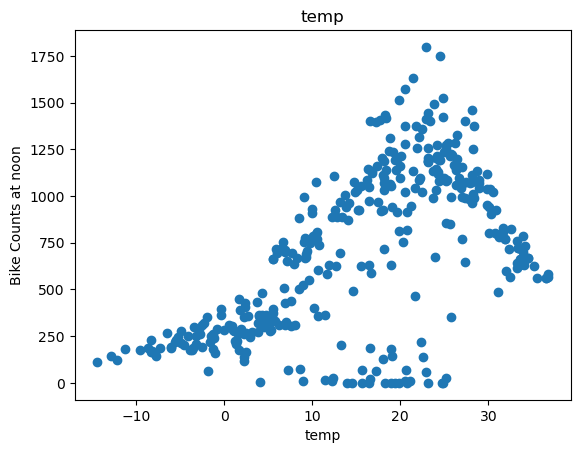

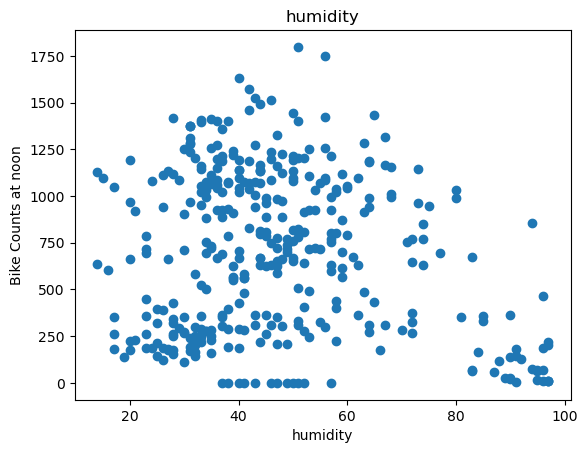

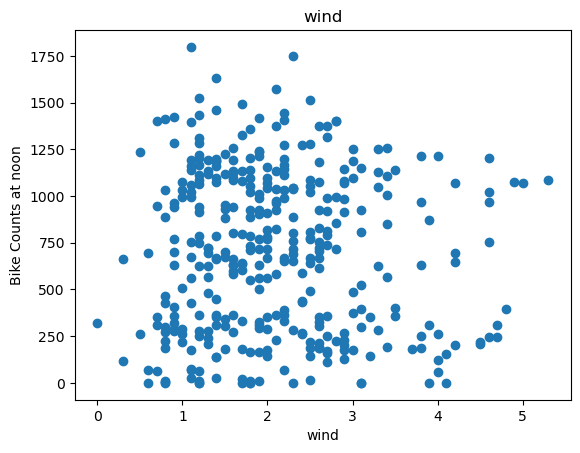

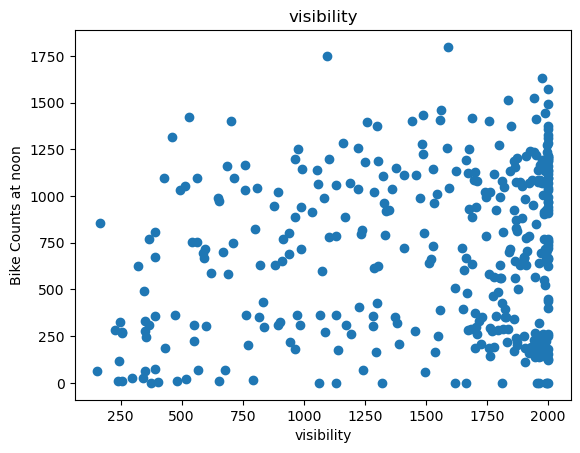

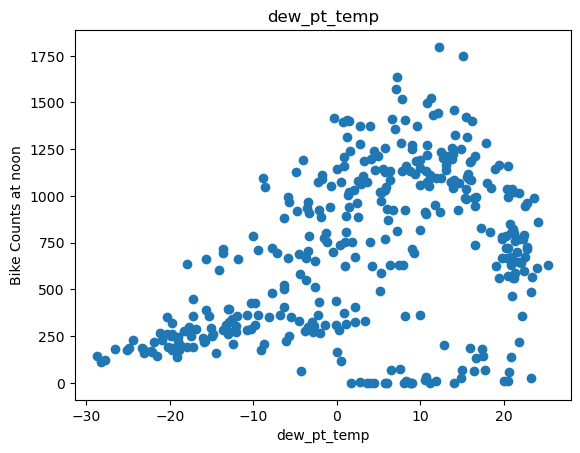

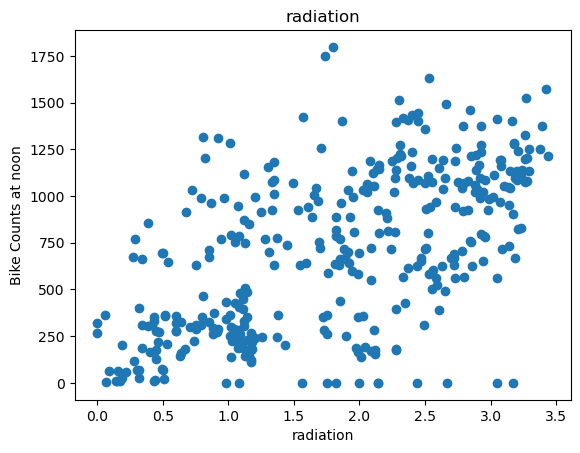

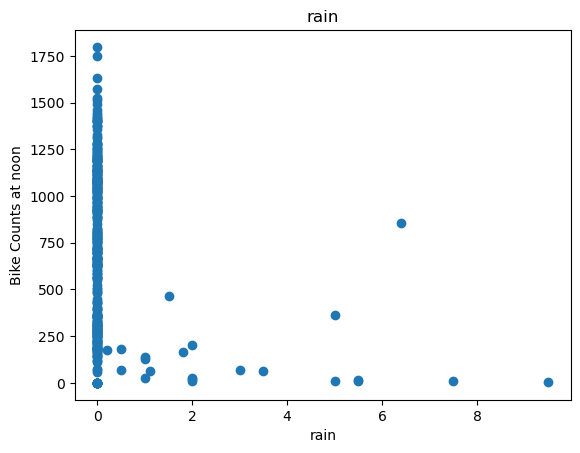

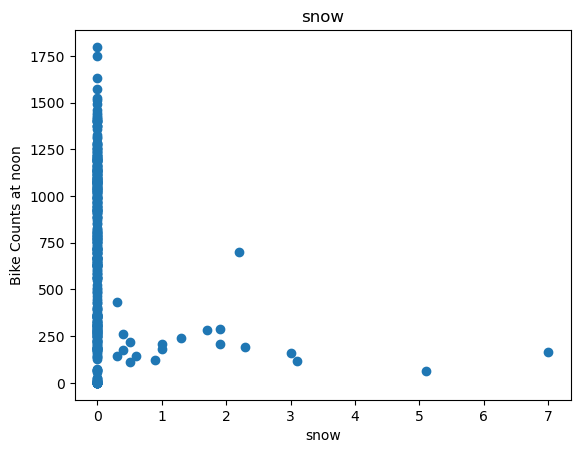

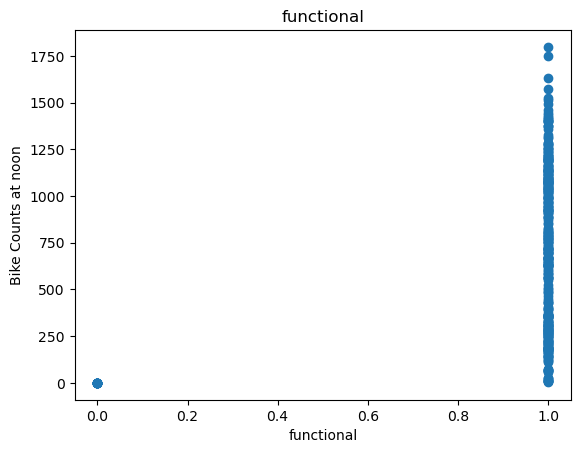

In [47]:
# plot bike count against each feature at 12:00 hours
for label in df.columns[1:]:
    plt.scatter(df[label], df['bike_counts'])
    plt.xlabel(label)
    plt.title(label)
    plt.ylabel('Bike Counts at noon')
    plt.show()
    

seems `temp`, `raduiation`, `dewpoint`, stc has some relationship with `count`, however, there are features which has no relation with counts, such as `functional`, etc. its better to drop these features.

In [114]:
# dropping wind, visibility and functional columns
df = df.drop(['wind', 'visibility', 'functional'], axis=1)
df.head()

,bike_counts,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


## Splitting the dataset into the Training set, Validation set, and Test set


In [49]:
train, valid, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

In [50]:
# Function to get X and y from the dataframe
def get_X_y(df, y_label, x_labels=None):
    dataframe = copy.deepcopy(df)       # deep copy is used to avoid the error of SettingWithCopyWarning in pandas

    # if x_labels are not provided, use all columns except y_label
    if  x_labels is None:
        X = dataframe.drop(y_label, axis=1).values     # .values is used to convert dataframe to numpy array
    # If only one x_label is provided, use that
    else:
        if len(x_labels) ==1:
            X = dataframe[x_labels[0]].values.reshape(-1,1)    # .reshape(-1,1) is used to convert 1D array to 2D array
        # If multiple x_labels are provided, use all of them
        else:
            X = dataframe[x_labels].values

    y = dataframe[y_label].values.reshape(-1,1)
    data = np.hstack((X,y))     # np.hstack is used to stack arrays in sequence horizontally (column wise)

    return data, X, y 

In [51]:
# Lets take only 1 feature and see how it performs
_, X_train, y_train = get_X_y(train, y_label='bike_counts', x_labels=['temp'])
_, X_valid, y_valid = get_X_y(valid, y_label='bike_counts', x_labels=['temp'])
_, X_test, y_test = get_X_y(test, y_label='bike_counts', x_labels=['temp'])

In [52]:
X_train, X_train.shape

(array([[ 22.5],
        [ 10.6],
        [  9.1],
        [ -4.6],
        [ -3.5],
        [ 28.4],
        [  6.6],
        [  2.9],
        [  2.2],
        [ -4.9],
        [  4.8],
        [ -6.5],
        [  4.3],
        [ 10. ],
        [ -5.5],
        [ -3.2],
        [  9.4],
        [  5.8],
        [ 33.8],
        [ 10.7],
        [ 16.2],
        [ 18.3],
        [ -3.7],
        [ 33.9],
        [ 19. ],
        [  5.3],
        [ 16.6],
        [ 24.4],
        [ 15.2],
        [ 18.2],
        [  3.7],
        [ 28.4],
        [  1.2],
        [ 26.4],
        [  7.6],
        [ 11.4],
        [  9. ],
        [ 30.8],
        [  6.9],
        [ 12.7],
        [ 23.2],
        [ 27.4],
        [ 25.7],
        [  1. ],
        [ 28.9],
        [  4.8],
        [  1.7],
        [ -2.3],
        [ -3.9],
        [ 33.8],
        [ 26.1],
        [  7. ],
        [ 28.9],
        [ 25. ],
        [ 28.1],
        [ 29.8],
        [ 26.4],
        [ -7.8],
        [ -1.3

## Simple Linear Regression


In [53]:
temp_reg = LinearRegression()
temp_reg.fit(X_train, y_train)

LinearRegression()

In [54]:
print(f'Regression Coefficient: {temp_reg.coef_} & Intercept: {temp_reg.intercept_}')

Regression Coefficient: [[23.43930186]] & Intercept: [353.62208821]


In [55]:
# R-squared value
temp_reg.score(X_test, y_test)

0.19974015254097754

This shows a +ve but weak correlation between `temp` and `count`

### Line of best-fit

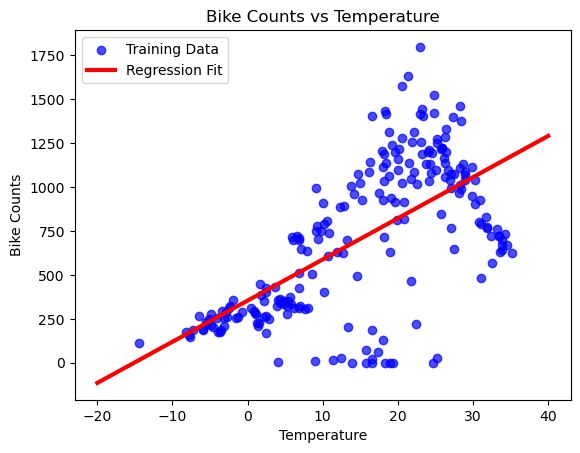

In [56]:
plt.scatter(X_train, y_train, label='Training Data', color='blue', alpha=.7)

# range for the best-fit line
x_range = tf.linspace(-20, 40, 100)
x = np.array(x_range).reshape(-1,1)        # .reshape(-1,1) is used to convert 1D array to 2D array
plt.plot(x, temp_reg.predict(x), label='Regression Fit', color='red', linewidth=3)

plt.xlabel('Temperature')
plt.ylabel('Bike Counts')
plt.title('Bike Counts vs Temperature')

plt.legend()
plt.show()


### Multiple Linear Regression

In [65]:
df.columns

Index(['bike_counts', 'temp', 'humidity', 'dew_pt_temp', 'radiation', 'rain',
       'snow'],
      dtype='object')

In [66]:
# Lets take all feature and see how it performs
train, valid, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

_, X_train, y_train = get_X_y(train, y_label='bike_counts', x_labels= df.columns[1:])
_, X_valid, y_valid = get_X_y(valid, y_label='bike_counts', x_labels= df.columns[1:])
_, X_test, y_test = get_X_y(test, y_label='bike_counts', x_labels= df.columns[1:])

In [67]:
all_reg = LinearRegression()
all_reg.fit(X_train, y_train)

LinearRegression()

In [68]:
all_reg.score(X_test, y_test)

0.3813436252318082

The regression score of R^2 is 0.39, which is an improvement.

## Regression with Neural Network

### Using Temperature data only

In [115]:
# Lets take all feature and see how it performs
train, valid, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

_, X_train_temp, y_train_temp = get_X_y(train, y_label='bike_counts', x_labels=['temp'])
_, X_valid_temp, y_valid_temp = get_X_y(valid, y_label='bike_counts', x_labels=['temp'])
_, X_test_temp, y_test_temp = get_X_y(test, y_label='bike_counts', x_labels=['temp'])

It helps when we normalize the features. This is because the weights are updated based on the input data. If the input data is not normalized, then the weights will be updated differently for different features. This will lead to a slower convergence.

In [116]:
# Normalization Layer
temp_normalizer = tf.keras.layers.Normalization(input_shape = (1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))       # .adapt is used to calculate the mean and variance, and store them in the layer & .reshape(-1) is used to convert 1D array to 2D array

In [117]:
# Neural Network: 1 hidden layer with 1 neuron with no activation function (simple linear regression)
temp_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(units=1)
])
    

In [118]:
# Compile the model using the standard 'adam' optimizer and the mean squared error or 'mse' loss function for regression.

temp_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [119]:
# Plot the model
def plot_history(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [MSE]')
    plt.legend()
    plt.grid(True)
    plt.show()


In [120]:
# Train the model for 1000 epochs
history = temp_model.fit(
    X_train_temp.reshape(-1), y_train_temp,
    epochs=1500, verbose=0,
    validation_data=(X_valid_temp, y_valid_temp)
    ) 
    

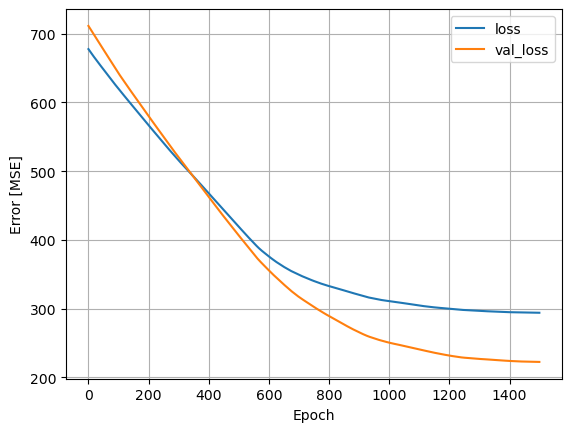

In [121]:
plot_history(history)

Validation and training loss observes largely a downwards trend, which is a good sign. However, the validation loss is much lower than the training loss, which indicates that the model is overfitting.

4/4 [==============================] - 0s 2ms/step


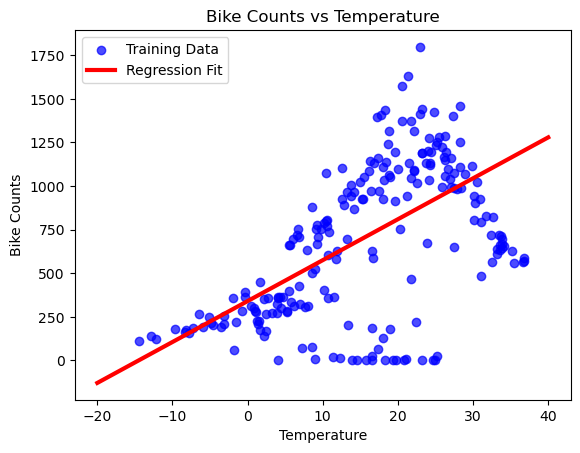

In [123]:
plt.scatter(X_train_temp, y_train_temp, label='Training Data', color='blue', alpha=.7)

# range for the best-fit line
x_range = tf.linspace(-20, 40, 100)
x = np.array(x_range).reshape(-1,1)        # .reshape(-1,1) is used to convert 1D array to 2D array
plt.plot(x, temp_model.predict(x), label='Regression Fit', color='red', linewidth=3)

plt.xlabel('Temperature')
plt.ylabel('Bike Counts')
plt.title('Bike Counts vs Temperature')

plt.legend()
plt.show()

The NN model also shows a similar trend line as regression model.

### Using all features

In [124]:
# Lets take all feature and see how it performs
train, valid, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

_, X_train, y_train = get_X_y(train, y_label='bike_counts', x_labels= df.columns[1:])
_, X_valid, y_valid = get_X_y(valid, y_label='bike_counts', x_labels= df.columns[1:])
_, X_test, y_test = get_X_y(test, y_label='bike_counts', x_labels= df.columns[1:])

In [127]:
# Normalization Layer
n_features = X_train.shape[1]
normalizer = tf.keras.layers.Normalization(input_shape = (n_features,), axis=None) 
normalizer.adapt(X_train)       # .adapt is used to calculate the mean and variance, and store them in the layer & .reshape(-1) is used to convert 1D array to 2D array

When dealing with more than one features, it is imp to consider multiple layers in the NN model. This is because the NN model is able to learn more complex relationships between the features and the target variable.

In [128]:
# Neural Network: 1 hidden layer with 1 neuron with no activation function (simple linear regression)
model = tf.keras.Sequential([
    normalizer,                                  # starting up with Normalization layer
    tf.keras.layers.Dense(units=64, activation='relu'),     # 1st hidden layer with 64 neurons and relu activation function
    tf.keras.layers.Dense(units=32, activation='relu'),     # 2nd hidden layer with 32 neurons and relu activation function
    tf.keras.layers.Dense(units=1)                          # output layer with 1 neuron and no activation function
])

In [129]:
# Compile the model using the standard 'adam' optimizer and mse loss function for regression.
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')


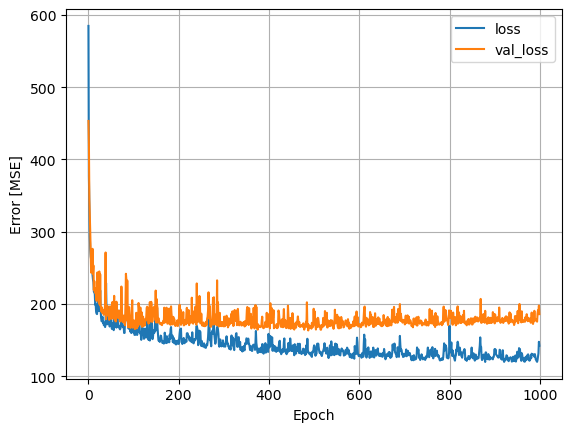

In [130]:
# Train the model for 1000 epochs
history = model.fit(
    X_train, y_train,
    epochs=1000, verbose=0,
    validation_data=(X_valid, y_valid))

plot_history(history)

* Initial Drastic Dip (0-50 epochs):
    1. Both training and validation losses decrease rapidly. This indicates that the model is learning and adjusting its weights and biases to fit the training data better.
    2. Since both losses decrease, it also indicates that whatever the model learned from the training set was generalizable to the validation set during these epochs.
<br>
<br>

* Post 50 epochs:
    1. The training loss continues to decrease, but the validation loss plateaus around 180 and doesn't improve.
    2. This suggests that the model might be overfitting. Overfitting occurs when the model performs well on the training data but doesn't generalize well to unseen data. This is a common challenge in machine learning.
    3. The continuous decrease in training loss indicates that the model is fitting more and more to the nuances and noise of the training data, which doesn't necessarily represent real-world patterns. Hence, it doesn't help in reducing the validation loss and can sometimes even make the validation loss increase (although in your case it plateaued).
<br>
<br>
* Interpretation and Recommendations:
    1. **Early Stopping:** Since validation loss plateaus and doesn't show improvement after a certain number of epochs, one could use a technique called "early stopping". This means stop training the model once the validation loss doesn't improve for a certain number of epochs. This can save computational resources and prevent the model from overfitting.

    2. **Regularization:** Consider adding regularization (like L1 or L2 regularization) to your neural network. Regularization can help prevent overfitting by adding a penalty to the loss for large weights.

    3. **Model Architecture:** One could experiment with your model's architecture. This includes the number of layers, the number of units in each layer, and the type of activation functions to use. Sometimes simpler architectures can generalize better.

    3. **Dropout:** Consider adding dropout layers in the neural network. Dropout is a form of regularization where random subsets of neurons are turned off during training, forcing the network to learn more robust features.

    4. **Learning Rate:** Adjusting the learning rate can also have an effect. Sometimes a smaller learning rate can help, but it will also require more epochs to converge. Conversely, a learning rate that's too high can cause oscillation in the loss.
<br>
<br>
In summary, the visualization suggests that your model might be overfitting after around 50 epochs. Using techniques like early stopping, regularization, adjusting the architecture, and experimenting with different learning rates can help improve the model's generalization on the validation set.

### Regularization

#### Implement Early Stopping

In [131]:
from tensorflow.keras.callbacks import EarlyStopping

In [132]:
# Lets take all feature and see how it performs
train, valid, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

_, X_train, y_train = get_X_y(train, y_label='bike_counts', x_labels= df.columns[1:])
_, X_valid, y_valid = get_X_y(valid, y_label='bike_counts', x_labels= df.columns[1:])
_, X_test, y_test = get_X_y(test, y_label='bike_counts', x_labels= df.columns[1:])

# Normalization Layer
n_features = X_train.shape[1]
normalizer = tf.keras.layers.Normalization(input_shape = (n_features,), axis=None) 
normalizer.adapt(X_train)       # .adapt is used to calculate the mean and variance, and store them in the layer & .reshape(-1) is used to convert 1D array to 2D array

# Compile the model using the standard 'adam' optimizer and mse loss function for regression.
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

* monitor: The metric you want to monitor (usually 'val_loss' for validation loss).
* patience: Number of epochs with no improvement after which training will be stopped. For example, patience=50 means "wait 50 epochs for a possible decrease in validation loss before stopping".
* verbose: Verbosity mode. 1 means it will print logs.
* restore_best_weights: If True, the model weights will be restored to the epoch with the best value of the monitored quantity. This ensures that even if the model starts overfitting, you'll get the version of the model that had the best performance on the validation set.

Epoch 1/1000
7/7 [==============================] - 1s 16ms/step - loss: 164.4242 - val_loss: 152.7658
Epoch 2/1000
7/7 [==============================] - 0s 4ms/step - loss: 142.3343 - val_loss: 159.9065
Epoch 3/1000
7/7 [==============================] - 0s 4ms/step - loss: 142.8551 - val_loss: 154.1576
Epoch 4/1000
7/7 [==============================] - 0s 4ms/step - loss: 141.6311 - val_loss: 153.1698
Epoch 5/1000
7/7 [==============================] - 0s 5ms/step - loss: 140.4442 - val_loss: 147.9566
Epoch 6/1000
7/7 [==============================] - 0s 5ms/step - loss: 141.2247 - val_loss: 170.8561
Epoch 7/1000
7/7 [==============================] - 0s 5ms/step - loss: 142.0983 - val_loss: 157.8311
Epoch 8/1000
7/7 [==============================] - 0s 4ms/step - loss: 137.7033 - val_loss: 168.0098
Epoch 9/1000
7/7 [==============================] - 0s 5ms/step - loss: 140.4228 - val_loss: 160.0683
Epoch 10/1000
7/7 [==============================] - 0s 4ms/step - loss: 139.8888

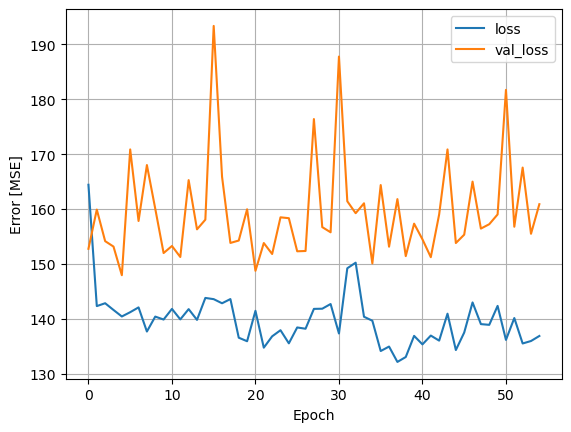

In [133]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1, restore_best_weights=True)

# Train the model for 1000 epochs
history = model.fit(
    X_train, y_train,
    epochs=1000,
    validation_data=(X_valid, y_valid), 
    callbacks=[early_stopping])

plot_history(history)


Appearently it stops at 55 epochs, which is close to the 50 epochs we set. This is a good sign that the model is not overfitting, and can use less resources to train the model.

#### Implement L1 (Lasso) and L2 (Ridge) regularization
Regularization is a technique used in machine learning and deep learning to penalize complex models, thereby preventing them from fitting the noise in the data, i.e., overfitting. Regularization can be applied to both linear models and neural networks. In neural networks, you'll often use L1 and/or L2 regularization on the weights.

* L1 regularization adds a penalty equal to the sum of the absolute value of the coefficients. Can result in sparse models (i.e. models with few coefficients); Many coefficients are zero.
* L2 regularization adds a penalty equal to the sum of the squared value of the coefficients. Can result in small coefficients; All coefficients are non-zero and small.
* Elastic Net regularization is a combination of L1 and L2 regularization. It adds both penalties to the loss function.
* Dropout is a form of regularization where random subsets of neurons are ignored during training. This forces the network to learn more robust features.



In [134]:
from tensorflow.keras import regularizers

In [135]:
# Lets take all feature and see how it performs
train, valid, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

_, X_train, y_train = get_X_y(train, y_label='bike_counts', x_labels= df.columns[1:])
_, X_valid, y_valid = get_X_y(valid, y_label='bike_counts', x_labels= df.columns[1:])
_, X_test, y_test = get_X_y(test, y_label='bike_counts', x_labels= df.columns[1:])

# Normalization Layer
n_features = X_train.shape[1]
normalizer = tf.keras.layers.Normalization(input_shape = (n_features,), axis=None) 
normalizer.adapt(X_train)       # .adapt is used to calculate the mean and variance, and store them in the layer & .reshape(-1) is used to convert 1D array to 2D array

# Neural Network: 1 hidden layer with 1 neuron with no activation function (simple linear regression)
model = tf.keras.Sequential([
    normalizer,                                  # starting up with Normalization layer
    tf.keras.layers.Dense(units=64, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(6,)),     # 1st hidden layer with 64 neurons and relu activation function & L2 regularization
    tf.keras.layers.Dense(units=32, activation='relu', kernel_regularizer=regularizers.l1(0.01)),                       # 2nd hidden layer with 32 neurons and relu activation function & L1 regularization
    tf.keras.layers.Dense(units=1)                                                                   # output layer with 1 neuron and no activation function
])

In [136]:
# Compile the model using the standard 'adam' optimizer and mse loss function for regression.
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

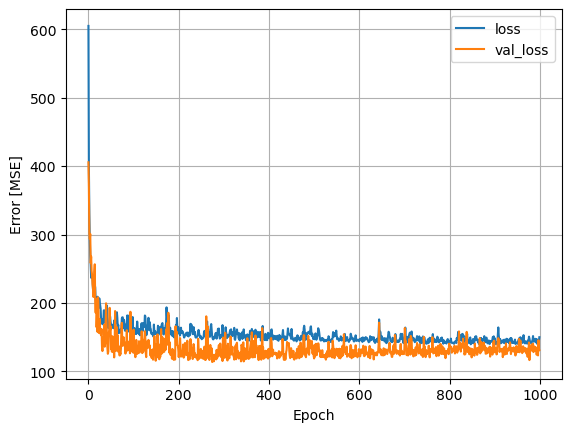

In [137]:
# Train the model for 1000 epochs
history = model.fit(
    X_train, y_train,
    epochs=1000, verbose=0,
    validation_data=(X_valid, y_valid))

plot_history(history)

1. **Immediate Drop in Losses:** Both the validation and training loss drop significantly in the beginning. This suggests that the model is quickly learning the dominant patterns in the data. This is a common phenomenon, especially in the early stages of training.

2. **Validation Loss Plateau and Slight Increase:**

    * After the initial drop, the validation loss plateaus and then shows a slight increase. The plateau indicates that the model has started to struggle in improving its performance on the validation set. This is where the model starts fitting the training data more closely, potentially including its noise and irregularities.
    * The slight increase in validation loss suggests that the model might be starting to overfit the training data. As the model becomes more specialized in fitting the training data, its ability to generalize to new, unseen data (in this case, the validation data) decreases.

3. **Training Loss Continues to Decline:** Despite the increase in validation loss, the training loss continues to decrease. This further supports the idea that the model is overfitting. As the model gets better at fitting the specific examples in the training set, the training loss goes down, but this doesn't necessarily translate to better performance on unseen data.

**Interpretation and Recommendations:**

Overfitting: The model is starting to overfit after around 100 epochs. Overfitting is indicated by the training loss continuing to decrease while the validation loss starts to increase. Essentially, the model is becoming too specialized to the training data and losing its ability to generalize.

**Early Stopping:** Considering the observations, it might be beneficial to stop training around where the validation loss plateaus or starts to increase, which seems to be around 100 epochs. This is where the concept of early stopping comes into play, which you mentioned earlier.

**Regularization Effect:** The fact that overfitting is happening gradually (rather than very sharply) and that the model didn't immediately fit all the noise in the training data can be attributed to the effects of L1 & L2 regularization. Regularization adds a penalty to the loss function based on the magnitude (and in the case of L1, the number) of the weights, which discourages the model from having very large weights and therefore from fitting the noise in the data.

**Further Steps:** If you're still observing overfitting despite using L1 & L2 regularization, you might consider:

Adjusting the regularization strength (often denoted as lambda or alpha in documentation).
Trying dropout, another form of regularization specifically designed for neural networks.
Using more data, if available, since models with more parameters benefit from more data.
Simplifying the model architecture, such as reducing the number of neurons or layers.
Remember, the goal isn't necessarily to get the training loss as low as possible, but to make the model generalize well to new, unseen data.

#### Adding Dropout with L1 & L2 regularization
During training, random subsets of neurons are ignored or "dropped out." This forces the network to learn more robust features and prevents overfitting.

In [138]:
from tensorflow.keras.layers import Dropout

In [139]:
# Lets take all feature and see how it performs
train, valid, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

_, X_train, y_train = get_X_y(train, y_label='bike_counts', x_labels= df.columns[1:])
_, X_valid, y_valid = get_X_y(valid, y_label='bike_counts', x_labels= df.columns[1:])
_, X_test, y_test = get_X_y(test, y_label='bike_counts', x_labels= df.columns[1:])

# Normalization Layer
n_features = X_train.shape[1]
normalizer = tf.keras.layers.Normalization(input_shape = (n_features,), axis=None) 
normalizer.adapt(X_train)       # .adapt is used to calculate the mean and variance, and store them in the layer & .reshape(-1) is used to convert 1D array to 2D array

# Neural Network: 1 hidden layer with 1 neuron with no activation function (simple linear regression)
model = tf.keras.Sequential([
    normalizer,                                  # starting up with Normalization layer
    tf.keras.layers.Dense(units=64, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(6,)),     # 1st hidden layer with 64 neurons and relu activation function & L2 regularization
    Dropout(0.2),                                                                                                       # Dropout layer with 20% dropout rate
    tf.keras.layers.Dense(units=32, activation='relu', kernel_regularizer=regularizers.l1(0.01)),                       # 2nd hidden layer with 32 neurons and relu activation function & L1 regularization
    Dropout(0.2),                                                                                                       # Dropout layer with 20% dropout rate
    tf.keras.layers.Dense(units=1)                                                                   # output layer with 1 neuron and no activation function
])

In [140]:
# Compile the model using the standard 'adam' optimizer and mse loss function for regression.
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

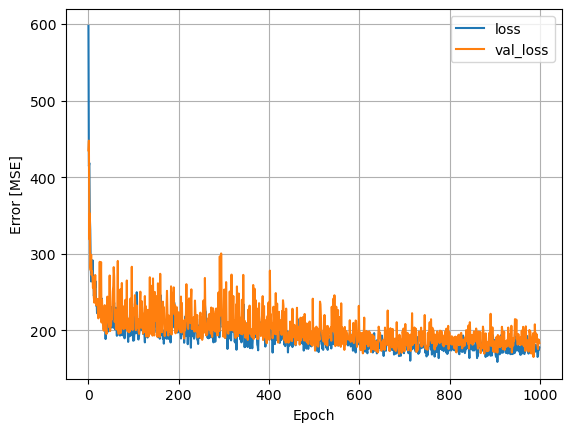

In [141]:
# Train the model for 1000 epochs
history = model.fit(
    X_train, y_train,
    epochs=1000, verbose=0,
    validation_data=(X_valid, y_valid))

plot_history(history)

1. **Immediate Drop in Loss:** This initial drop in both the training and validation loss shows that the model quickly learns the dominant patterns in the data. This suggests that the model's architecture and parameters are capable of capturing the underlying patterns of the data.

2. **Consistent Downward Trend:** Both training and validation loss exhibit a downward trend over 1000 epochs, which indicates that the model is still learning and improving its performance on both sets as epochs progress.

3. **Frequent Large Spikes in Validation Loss:** The presence of frequent large spikes in the validation loss (even one reaching 300 at around the 300th epoch) suggests instability during training. Here's a breakdown:

    * **Dropout:** Dropout is a regularization technique where during training, random subsets of neurons are "dropped out", or temporarily turned off, for the particular training iteration. This introduces noise into the training process. In some cases, especially with a high learning rate, it can lead to some instability in convergence since the network is consistently trying to adjust to the turned-off neurons.

    * **Learning Rate:** The learning rate of 0.1 might be a bit high. A high learning rate can cause the optimizer to overshoot the minimum of the loss function, resulting in these oscillations or spikes in the validation loss. The dropout combined with a high learning rate might exacerbate these oscillations.

    * **Regularization:** Using both L1 and L2 regularization simultaneously can add complexity to the training dynamics. These regularizations add penalties to the loss function based on the weights, which, combined with dropout and potentially a high learning rate, might be causing some of the observed instability.

**Recommendations and Next Steps:**

Adjust Learning Rate: Consider reducing the learning rate. You can experiment with values like 0.01 or even 0.001. This might lead to more stable, albeit slower, convergence. You can also use learning rate schedules or decay to dynamically adjust it during training.

Early Stopping with Restore Best Weights: Consider using early stopping with the restore_best_weights option. This way, even if there's a spike in the validation loss, the model will revert back to the weights that produced the lowest validation loss.

Regularization Strength: You may want to adjust the strength (lambda value) of the L1 and L2 regularizations. A too-strong regularization can also impact the training dynamics.

Batch Size: If you're using the default batch size, consider increasing it. A larger batch size can stabilize training, especially when using dropout.

Dropout Rate: Experiment with different dropout rates. Sometimes a smaller dropout rate (like 10%) might work better, especially in conjunction with other regularization methods.

Other Optimizers: While Adam is a good general-purpose optimizer, there's no harm in trying others like RMSProp or even a well-tuned SGD to see if they provide more stable convergence.

In essence, neural network training can be thought of as a balancing act. Regularizations, dropout, learning rates, etc., are all tools at your disposal, but their optimal settings often depend on the specific data and problem at hand. Adjusting these factors through experimentation is a key part of the deep learning model development process.

#### Elastic Net with Dropout and altered learning rate

In [142]:
# Lets take all feature and see how it performs
train, valid, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

_, X_train, y_train = get_X_y(train, y_label='bike_counts', x_labels= df.columns[1:])
_, X_valid, y_valid = get_X_y(valid, y_label='bike_counts', x_labels= df.columns[1:])
_, X_test, y_test = get_X_y(test, y_label='bike_counts', x_labels= df.columns[1:])

# Normalization Layer
n_features = X_train.shape[1]
normalizer = tf.keras.layers.Normalization(input_shape = (n_features,), axis=None) 
normalizer.adapt(X_train)       # .adapt is used to calculate the mean and variance, and store them in the layer & .reshape(-1) is used to convert 1D array to 2D array

# Neural Network: 1 hidden layer with 1 neuron with no activation function (simple linear regression)
model = tf.keras.Sequential([
    normalizer,                                  # starting up with Normalization layer
    tf.keras.layers.Dense(units=64, activation='relu', 
                          kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01), 
                          input_shape=(6,)),     # 1st hidden layer with 64 neurons and relu activation function & ElasticNet regularization
    Dropout(0.2),                                                                                                       # Dropout layer with 20% dropout rate
    tf.keras.layers.Dense(units=32, activation='relu', 
                          kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)),    # 2nd hidden layer with 32 neurons and relu activation function & ElasticNet regularization
    Dropout(0.2),                                                                                                       # Dropout layer with 20% dropout rate
    tf.keras.layers.Dense(units=1)                                                                   # output layer with 1 neuron and no activation function
])

In [143]:
# Compile the model using the standard 'adam' optimizer and mse loss function for regression.
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss='mean_absolute_error')

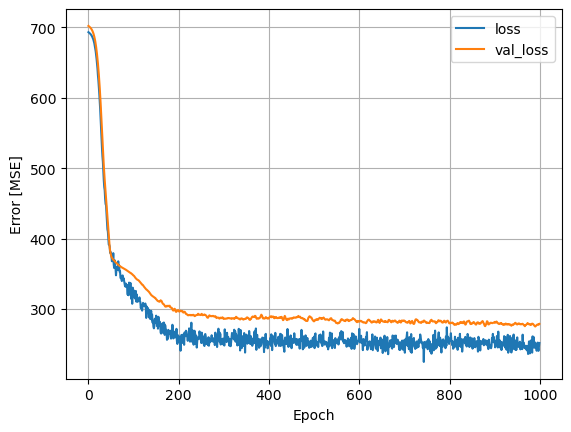

In [144]:
# Train the model for 1000 epochs
history = model.fit(
    X_train, y_train,
    epochs=1000, verbose=0,
    validation_data=(X_valid, y_valid))

plot_history(history)


The drastic decrease in both training and validation loss in the beginning shows that the model is quickly learning the dominant patterns in the data. However, The overfitting is still present, as the validation loss is still higher than the training loss.